In [1]:
import os

import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import collections

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [37]:
ladd_anotation_path = '../../../ladd-and-weights/dataset/full_train_ds/Annotations/'
ipsar_anotation_path = '../../../ladd-and-weights/dataset/3rd_party/heridal/trainImages/labels/'


In [38]:
def parse_voc_xml(node: ET.Element) -> Dict[str, Any]:
    voc_dict: Dict[str, Any] = {}
    children = list(node)
    if children:
        def_dic: Dict[str, Any] = collections.defaultdict(list)
        for dc in map(parse_voc_xml, children):
            for ind, v in dc.items():
                def_dic[ind].append(v)
        if node.tag == 'annotation':
            def_dic['object'] = [def_dic['object']]
        voc_dict = {
            node.tag:
                {ind: v[0] if len(v) == 1 else v
                 for ind, v in def_dic.items()}
        }
    if node.text:
        text = node.text.strip()
        if not children:
            voc_dict[node.tag] = text
    return voc_dict

In [39]:
def get_imgSize_and_list_of_yxyx(xml_path):
    mytree = parse_voc_xml(ET.parse(xml_path).getroot())
    xyxy=[]
    if 'annotation' not in mytree:
        return ((0,0),())
    for p in mytree['annotation']['object']:
        y1=int(p['bndbox']['ymin'])
        x1=int(p['bndbox']['xmin'])
        y2=int(p['bndbox']['ymax'])
        x2=int(p['bndbox']['xmax'])
        xyxy.append(((x1,y1),(x2,y2)))
    size=(int(mytree['annotation']['size']['width']),int(mytree['annotation']['size']['height']))
    return size, xyxy

In [40]:
def get_xywh_from_point(size,points,file_id):
    w,h=size
    x=((points[0][0]+points[1][0])/2)/w
    y=((points[0][1]+points[1][1])/2)/h
    im_w=abs((points[0][0]-points[1][0]))/w
    im_h=abs((points[0][1]-points[1][1]))/h
    return x,y,im_w,im_h,file_id

In [41]:
ladd_coords = pd.DataFrame(columns = ['x','y','w','h','file'])
for xml_name in os.listdir(ladd_anotation_path):
    if not os.path.isfile(os.path.join(ladd_anotation_path,xml_name)):
        continue
    file_id,_ = os.path.splitext(xml_name)
    img_size, points_yxyx=get_imgSize_and_list_of_yxyx(os.path.join(ladd_anotation_path,xml_name))
    xywhs=[get_xywh_from_point(img_size,xyxy_single,file_id) for xyxy_single in points_yxyx]
    ladd_coords = ladd_coords.append(pd.DataFrame(xywhs,columns = ['x','y','w','h','file']))

In [42]:
ipsar_coords = pd.DataFrame(columns = ['x','y','w','h','file'])
empty_annotations = []
ipsar_total = 0
for xml_name in os.listdir(ipsar_anotation_path):
    if not os.path.isfile(os.path.join(ipsar_anotation_path,xml_name)):
        continue
    ipsar_total += 1
    file_id,_ = os.path.splitext(xml_name)
    img_size, points_yxyx=get_imgSize_and_list_of_yxyx(os.path.join(ipsar_anotation_path,xml_name))
    if img_size==(0,0):
        empty_annotations.append(file_id)
    else:
        xywhs=[get_xywh_from_point(img_size,xyxy_single,file_id) for xyxy_single in points_yxyx]
        ipsar_coords = ipsar_coords.append(pd.DataFrame(xywhs,columns = ['x','y','w','h','file']))

print('Files without annotations: ' + str(len(empty_annotations)) + ' from ' + str(ipsar_total))

Files without annotations: 563 from 1548


In [8]:
ladd_coords.groupby('file').count()['x'].mean()

3.434113712374582

In [9]:
ipsar_coords.groupby('file').count()['x'].mean()

2.9360406091370557

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'h'}>]], dtype=object)

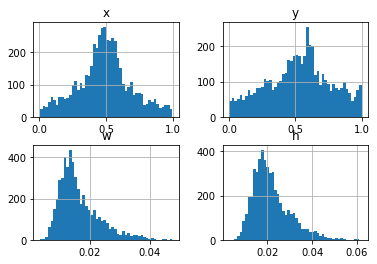

In [11]:
ladd_coords[['x','y','w','h']].hist(bins = 50)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'h'}>]], dtype=object)

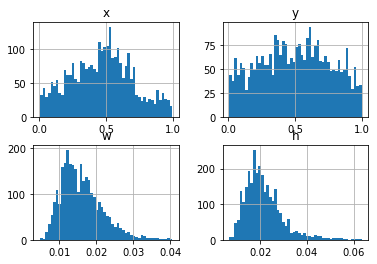

In [12]:
ipsar_coords[['x','y','w','h']].hist(bins = 50)